In [1]:
%config IPCompleter.greedy=True
from IPython.display import IFrame

import os
import time

import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn import preprocessing as prep
import sklearn.model_selection as model_selection

import tensorflow as tf
from tensorflow import keras
import keras.backend as K

import h5py

Using TensorFlow backend.


In [2]:
TEST_IDS = [map_id.split('.')[0] for map_id in sorted(os.listdir('00_Data/fMRI_test'))]
TRAIN_IDS = [map_id.split('.')[0] for map_id in sorted(os.listdir('00_Data/fMRI_train'))]
ALL_IDS = TRAIN_IDS + TEST_IDS

In [3]:
data = pd.read_csv('00_Data/train_scores_full.csv')
data

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
0,10001,57.436077,30.571975,62.553736,53.325130,51.427998
1,10002,59.580851,50.969456,67.470628,60.651856,58.311361
2,10004,71.413018,53.152498,58.012103,52.418389,62.536641
3,10007,38.617381,49.197021,65.674285,40.151376,34.096421
4,10008,35.326582,15.769168,65.782269,44.643805,50.448485
...,...,...,...,...,...,...
5872,21654,53.103634,50.951656,62.168022,49.389400,53.020847
5873,21665,38.246437,48.018227,59.522285,45.697098,53.208160
5874,21674,69.414169,58.593918,60.298779,49.865669,47.863167
5875,21693,62.009209,54.272484,60.474388,52.325031,52.989803


In [4]:
def get_inputs(idx):
    #MRI inputs
    patient_SM = h5py.File('00_Data/fMRI_all/{0}.mat'.format(idx), mode='r')
    patient_SM = np.array(patient_SM.get('SM_feature'))
#     print(patient_SM.shape)
    k = 1
    ki_padding = 3
    
    arr_regions = []
    for i in range(patient_SM.shape[0]):
        sample_map = patient_SM[i,:,:,:]
        if k > 1:
            map_shape = sample_map.shape
            shape_pad = ((map_shape[0]//k + 1)*k - map_shape[0],
                         (map_shape[1]//k + 1)*k - map_shape[1],
                         (map_shape[2]//k + 1)*k - map_shape[2])

            npad = (((0 if shape_pad[0]%2==0 else shape_pad[0]//2), (shape_pad[0]//2 if shape_pad[0]%2==0 else shape_pad[0]//2+1)),    
                    ((0 if shape_pad[1]%2==0 else shape_pad[0]//2), (shape_pad[1]//2 if shape_pad[1]%2==0 else shape_pad[1]//2+1)),    
                    ((0 if shape_pad[2]%2==0 else shape_pad[0]//2), (shape_pad[2]//2 if shape_pad[2]%2==0 else shape_pad[2]//2+1)))

            sample_map_padded = np.pad(sample_map, pad_width=npad, mode='constant', constant_values=0)

            sx = sample_map_padded.shape[0] / k
            sy = sample_map_padded.shape[1] / k
            sz = sample_map_padded.shape[2] / k
            for kz in range(k):
                for ky in range(k):
                    for kx in range(k):
                        ki_region = sample_map_padded[int(kx*sx): int(kx*sx + sx - 1), 
                                                     int(ky*sy): int(ky*sy + sy - 1), 
                                                     int(kz*sz): int(kz*sz + sz - 1)]
                        #padding i-th region by 3 pixels
                        ki_region_padded = np.pad(ki_region, pad_width=ki_padding, mode='constant', constant_values=0)
                        arr_regions.append(ki_region_padded)
        else:
            map_shape = sample_map.shape
            shape_pad = ((map_shape[0]//2 + 1)*2 - map_shape[0],
                         (map_shape[1]//2 + 1)*2 - map_shape[1],
                         (map_shape[2]//2 + 1)*2 - map_shape[2])

            npad = (((0 if shape_pad[0]%2==0 else shape_pad[0]//2+1), (0 if shape_pad[0]%2==0 else shape_pad[0]//2+1)),    
                    ((0 if shape_pad[1]%2==0 else shape_pad[0]//2+1), (0 if shape_pad[1]%2==0 else shape_pad[1]//2+1)),    
                    ((0 if shape_pad[2]%2==0 else shape_pad[0]//2+1), (0 if shape_pad[2]%2==0 else shape_pad[2]//2+1)))

            sample_map_padded = np.pad(sample_map, pad_width=npad, mode='constant', constant_values=0)
            
#             sample_map_padded = np.pad(sample_map, pad_width=ki_padding, mode='constant', constant_values=0)
            arr_regions.append(sample_map_padded)
            
    X_mri = np.stack(arr_regions, axis=3)
#     print(X_mri.shape)
    return X_mri, X_mri

In [5]:
# get_inputs('10002')[0].shape

In [6]:
def new_py_function(func, inp, Tout, name=None):
    
    def wrapped_func(*flat_inp):
        reconstructed_inp = tf.nest.pack_sequence_as(inp, flat_inp,
                                                     expand_composites=True)
        out = func(*reconstructed_inp)
        return tf.nest.flatten(out, expand_composites=True)
    
    flat_Tout = tf.nest.flatten(Tout, expand_composites=True)
    flat_out = tf.py_function(func=wrapped_func, 
                              inp=tf.nest.flatten(inp, expand_composites=True),
                              Tout=[_tensor_spec_to_dtype(v) for v in flat_Tout],
                              name=name)
    spec_out = tf.nest.map_structure(_dtype_to_tensor_spec, Tout, expand_composites=True)
    out = tf.nest.pack_sequence_as(spec_out, flat_out, expand_composites=True)
    return out

def _dtype_to_tensor_spec(v):
    return tf.TensorSpec(None, v) if isinstance(v, tf.dtypes.DType) else v

def _tensor_spec_to_dtype(v):
    return v.dtype if isinstance(v, tf.TensorSpec) else v

In [7]:
def get_dataset(data, batch_size):
    data = np.array([int(i) for i in data])
    data = tf.data.Dataset.from_tensor_slices(data)
    data = data.shuffle(buffer_size=4000, seed=30, reshuffle_each_iteration=True)
    
    data = data.map(lambda idx: new_py_function(get_inputs, inp=[idx], 
                                                    Tout=(tf.TensorSpec(shape=(None, 52, 66, 56, 53), dtype=tf.dtypes.float64),
                                                          tf.TensorSpec(shape=(None, 52, 66, 56, 53), dtype=tf.dtypes.float64)), name=None), 
                     num_parallel_calls=tf.data.experimental.AUTOTUNE, 
                     deterministic=False)
#     data = data.map(lambda idx: tf.py_function(get_inputs, inp=[idx], 
#                                                     Tout=tf.float64, name=None), 
#                      num_parallel_calls=tf.data.experimental.AUTOTUNE, 
#                      deterministic=False)
    data = data.batch(batch_size, drop_remainder=False)
    data = data.prefetch(tf.data.experimental.AUTOTUNE)
    return data

In [8]:
# np.array(ALL_IDS)

In [9]:
# data['Id'].values

In [10]:
# np.array([int(i) for i in ALL_IDS])

In [11]:
# train, test = model_selection.train_test_split(data, test_size=0.2, shuffle=True, random_state=30)
# train, val = model_selection.train_test_split(train, test_size=0.2, shuffle=True, random_state=30)

In [12]:
batch_size = 8

ds_train = get_dataset(ALL_IDS, batch_size)
# ds_val = get_dataset(val, batch_size)
# ds_test = get_dataset(test, batch_size)

In [13]:
# for i in ds_train.take(1):
#     pass

In [14]:
INPUT_SHAPE_mri = (52, 66, 56, 53)

In [15]:
# class ClusteringLayer(keras.layers.Layer):
#     """
#     Clustering layer converts input sample (feature) to soft label.

#     # Example
#     ```
#         model.add(ClusteringLayer(n_clusters=10))
#     ```
#     # Arguments
#         n_clusters: number of clusters.
#         weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
#         alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
#     # Input shape
#         2D tensor with shape: `(n_samples, n_features)`.
#     # Output shape
#         2D tensor with shape: `(n_samples, n_clusters)`.
#     """

#     def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
#         if 'input_shape' not in kwargs and 'input_dim' in kwargs:
#             kwargs['input_shape'] = (kwargs.pop('input_dim'),)
#         super(ClusteringLayer, self).__init__(**kwargs)
#         self.n_clusters = n_clusters
#         self.alpha = alpha
#         self.initial_weights = weights
#         self.input_spec = InputSpec(ndim=2)

#     def build(self, input_shape):
#         assert len(input_shape) == 2
#         input_dim = input_shape[1]
#         self.input_spec = keras.layers.InputSpec(dtype=K.floatx(), shape=(None, input_dim))
#         self.clusters = self.add_weight((self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
#         if self.initial_weights is not None:
#             self.set_weights(self.initial_weights)
#             del self.initial_weights
#         self.built = True

#     def call(self, inputs, **kwargs):
#         """ student t-distribution, as same as used in t-SNE algorithm.        
#                  q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
#                  q_ij can be interpreted as the probability of assigning sample i to cluster j.
#                  (i.e., a soft assignment)
#         Arguments:
#             inputs: the variable containing data, shape=(n_samples, n_features)
#         Return:
#             q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
#         """
#         q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
#         q **= (self.alpha + 1.0) / 2.0
#         q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
#         return q

#     def compute_output_shape(self, input_shape):
#         assert input_shape and len(input_shape) == 2
#         return input_shape[0], self.n_clusters

#     def get_config(self):
#         config = {'n_clusters': self.n_clusters}
#         base_config = super(ClusteringLayer, self).get_config()
#         return dict(list(base_config.items()) + list(config.items()))

In [16]:
def create_model(input_shape, filters=[32, 16, 8, 2]):
#     if input_shape[0] % 8 == 0:
#         pad3 = 'same'
#     else:
#         pad3 = 'valid'
    
    #============================================================================
    # CNN for MRI images processing
    #============================================================================
    inputs_mri = keras.layers.Input(shape=INPUT_SHAPE_mri, name='inpupt_mri')

    # convolution block #1
    x = keras.layers.Conv3D(filters[0], kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                                  kernel_initializer=keras.initializers.he_normal(seed=30),
                                  bias_initializer=keras.initializers.Constant(0.01))(inputs_mri)
    x = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(x)
    x = keras.layers.Conv3D(filters[0], kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                                  kernel_initializer=keras.initializers.he_normal(seed=30),
                                  bias_initializer=keras.initializers.Constant(0.01))(x)
    x = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(x)
    x = keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2,2,2))(x)
#     x, p1_idx = tf.nn.max_pool_with_argmax(x, ksize=[2], strides=[2], padding='SAME', name="p1")
    x = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                              beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                              moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                              beta_constraint=None, gamma_constraint=None)(x)

    # convolution block #2
    x = keras.layers.Conv3D(filters[1], kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                                  kernel_initializer=keras.initializers.he_normal(seed=30),
                                  bias_initializer=keras.initializers.Constant(0.01))(x)
    x = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(x)
    x = keras.layers.Conv3D(filters[1], kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                                  kernel_initializer=keras.initializers.he_normal(seed=30),
                                  bias_initializer=keras.initializers.Constant(0.01))(x)
    x = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(x)
    x = keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2,2,2))(x)
    x = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                              beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                              moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                              beta_constraint=None, gamma_constraint=None)(x)

    # convolution block #3
    x = keras.layers.Conv3D(filters[2], kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                                  kernel_initializer=keras.initializers.he_normal(seed=30),
                                  bias_initializer=keras.initializers.Constant(0.01))(x)
    x = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(x)
    x = keras.layers.Conv3D(filters[2], kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                                  kernel_initializer=keras.initializers.he_normal(seed=30),
                                  bias_initializer=keras.initializers.Constant(0.01))(x)
    x = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(x)
    x = keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2,2,2))(x)
    x = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                              beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                              moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                              beta_constraint=None, gamma_constraint=None)(x)

    # convolution block #4
#     x = keras.layers.Conv3D(filters[3], kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
#                                   kernel_initializer=keras.initializers.he_normal(seed=30),
#                                   bias_initializer=keras.initializers.Constant(0.01))(x)
#     x = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(x)
#     x = keras.layers.Conv3D(filters[3], kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
#                                   kernel_initializer=keras.initializers.he_normal(seed=30),
#                                   bias_initializer=keras.initializers.Constant(0.01))(x)
#     x = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(x)
#     x = keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2,2,2))(x)
#     x = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
#                                               beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
#                                               moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
#                                               beta_constraint=None, gamma_constraint=None)(x)
    
#     shape_before_flattening = K.int_shape(x)

    flatten = keras.layers.Flatten(data_format='channels_last')(x)

    encoded = keras.layers.Dense(2,
                               kernel_initializer=keras.initializers.he_normal(seed=30),
                               bias_initializer=keras.initializers.Constant(5.))(flatten)
    encoded = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(encoded)
    

#     filters=[64, 32, 16, 8, 2]
#     INPUT_SHAPE_mri = (52, 66, 56, 53)
    
    # Decoder
    x = keras.layers.Dense(filters[2]*int(input_shape[0]/8)*int(input_shape[1]/8)*int(input_shape[2]/8),
                           kernel_initializer=keras.initializers.he_normal(seed=30),
                           bias_initializer=keras.initializers.Constant(5.))(encoded)
    
    x = keras.layers.Reshape((int(input_shape[0]/8), int(input_shape[1]/8), int(input_shape[2]/8), filters[2]))(x)
    
    # convolution block #4
#     x = tf.keras.layers.UpSampling3D(size=(2, 2, 2))(x)
#     x = tf.keras.layers.Conv3DTranspose(filters[2], kernel_size=(1, 1, 2), strides=(1,1,1), padding='valid',
#                                         kernel_initializer=keras.initializers.he_normal(seed=30),
#                                         bias_initializer=keras.initializers.Constant(0.01))(x)
#     x = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(x)
    
    # convolution block #3
    x = tf.keras.layers.UpSampling3D(size=(2, 2, 2))(x)
    x = tf.keras.layers.Conv3DTranspose(filters[2], kernel_size=(2, 1, 1), strides=(1,1,1), padding='valid',
                                        kernel_initializer=keras.initializers.he_normal(seed=30),
                                        bias_initializer=keras.initializers.Constant(0.01))(x)
    x = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(x)
    x = tf.keras.layers.Conv3DTranspose(filters[2], kernel_size=(2, 1, 1), strides=(1,1,1), padding='same',
                                        kernel_initializer=keras.initializers.he_normal(seed=30),
                                        bias_initializer=keras.initializers.Constant(0.01))(x)
    x = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(x)
    
    # convolution block #2
    x = tf.keras.layers.UpSampling3D(size=(2, 2, 2))(x)
    x = tf.keras.layers.Conv3DTranspose(filters[1], kernel_size=(1, 2, 1), strides=(1,1,1), padding='valid',
                                        kernel_initializer=keras.initializers.he_normal(seed=30),
                                        bias_initializer=keras.initializers.Constant(0.01))(x)
    x = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(x)
    x = tf.keras.layers.Conv3DTranspose(filters[1], kernel_size=(1, 2, 1), strides=(1,1,1), padding='same',
                                        kernel_initializer=keras.initializers.he_normal(seed=30),
                                        bias_initializer=keras.initializers.Constant(0.01))(x)
    x = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(x)
    
    # convolution block #1
    x = tf.keras.layers.UpSampling3D(size=(2, 2, 2))(x)
    x = tf.keras.layers.Conv3DTranspose(filters[0], kernel_size=(1, 1, 1), strides=(1,1,1), padding='valid',
                                        kernel_initializer=keras.initializers.he_normal(seed=30),
                                        bias_initializer=keras.initializers.Constant(0.01))(x)
    x = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(x)
    x = tf.keras.layers.Conv3DTranspose(filters[0], kernel_size=(1, 1, 1), strides=(1,1,1), padding='same',
                                        kernel_initializer=keras.initializers.he_normal(seed=30),
                                        bias_initializer=keras.initializers.Constant(0.01))(x)
    x = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(x)
    x = tf.keras.layers.Conv3DTranspose(input_shape[3], kernel_size=(1, 1, 1), strides=(1,1,1), padding='valid',
                                        kernel_initializer=keras.initializers.he_normal(seed=30),
                                        bias_initializer=keras.initializers.Constant(0.01))(x)
    x = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(x)
    
    # Output
#     decoded = keras.layers.Conv3D(53, kernel_size=(3, 3, 3), activation='sigmoid', padding='same')(x)
    decoded = x

    autoencoder = keras.Model(inputs=inputs_mri, outputs=decoded, name='autoencoder')
    encoder = keras.Model(inputs=inputs_mri, outputs=encoded, name='encoder')

    optim = tf.keras.optimizers.Adadelta(learning_rate=0.001, rho=0.95)

    METRICS = [keras.metrics.RootMeanSquaredError(name='rmse')]

    autoencoder.compile(loss='mse', metrics=METRICS, optimizer=optim)
#     encoder.compile(loss='mse', metrics=METRICS, optimizer=optim)
    return autoencoder, encoder

In [17]:
# filters=[64, 32, 16, 8, 2]
# input_shape = (52, 66, 56, 53)
# # filters[3]*int(input_shape[0]/8)*int(input_shape[0]/8)
# (int(input_shape[0]/8), int(input_shape[1]/8), int(input_shape[2]/8), filters[2])
# filters[2]*int(input_shape[0]/8)*int(input_shape[0]/8)

In [18]:
autoencoder, encoder = create_model(INPUT_SHAPE_mri)

In [19]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inpupt_mri (InputLayer)      [(None, 52, 66, 56, 53)]  0         
_________________________________________________________________
conv3d (Conv3D)              (None, 52, 66, 56, 32)    45824     
_________________________________________________________________
p_re_lu (PReLU)              (None, 52, 66, 56, 32)    6150144   
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 52, 66, 56, 32)    27680     
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 52, 66, 56, 32)    6150144   
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 26, 33, 28, 32)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 33, 28, 32)    

In [20]:
### checkpoint_dir = './99_Training_checkpoints/mri-fnc-loading'

In [21]:
# model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

In [22]:
# callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
#                                               min_delta=0.001, 
#                                               patience=10, 
#                                               verbose=1, 
#                                               mode='min',
#                                               baseline=None, 
#                                               restore_best_weights=True)]

In [23]:
checkpoint_prefix = os.path.join('./99_Training_checkpoints/mri_clustering', "ckpt_{epoch}")

callbacks = [tf.keras.callbacks.TensorBoard(log_dir='./99_Logs/mri_clustering'),
             tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                                save_weights_only=True),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              min_delta=0.001, 
                                              patience=5, 
                                              verbose=1, 
                                              mode='min',
                                              baseline=None, 
                                              restore_best_weights=True)]

In [24]:
with tf.device('/GPU:0'):
# with tf.device('/CPU:0'):
    hist = autoencoder.fit(ds_train,
                     validation_data=ds_train,
                     callbacks=callbacks,
                     epochs=400,
                     verbose=1)

Epoch 1/400
1470/1470 [==============================] - 8630s 6s/step - loss: 1.2870 - rmse: 1.1345 - val_loss: 0.7527 - val_rmse: 0.8676
Epoch 2/400
1470/1470 [==============================] - 8586s 6s/step - loss: 0.6158 - rmse: 0.7847 - val_loss: 0.5071 - val_rmse: 0.7121
Epoch 3/400
1470/1470 [==============================] - 8569s 6s/step - loss: 0.4421 - rmse: 0.6649 - val_loss: 0.3925 - val_rmse: 0.6265
Epoch 4/400
1470/1470 [==============================] - 8578s 6s/step - loss: 0.3654 - rmse: 0.6045 - val_loss: 0.3449 - val_rmse: 0.5872
Epoch 5/400
1470/1470 [==============================] - 8574s 6s/step - loss: 0.3325 - rmse: 0.5766 - val_loss: 0.3227 - val_rmse: 0.5681
Epoch 6/400
1470/1470 [==============================] - 8629s 6s/step - loss: 0.3165 - rmse: 0.5626 - val_loss: 0.3116 - val_rmse: 0.5582
Epoch 7/400
1470/1470 [==============================] - 8830s 6s/step - loss: 0.3085 - rmse: 0.5554 - val_loss: 0.3060 - val_rmse: 0.5532
Epoch 8/400
1470/1470 [====

In [25]:
autoencoder.save_weights('./99_Training_checkpoints/mri_clustering/model_weights_02.h5')
# tf.keras.models.save_model(autoencoder, 
#                            filepath='./99_Training_checkpoints/mri_clustering/model_02.h5', overwrite=True, include_optimizer=True, save_format=None,
#     signatures=None, options=None
# )

In [30]:
autoencoder.load_weights('./99_Training_checkpoints/mri_clustering/model_weights_02.h5')

Text(0.5, 1.0, 'Loss')

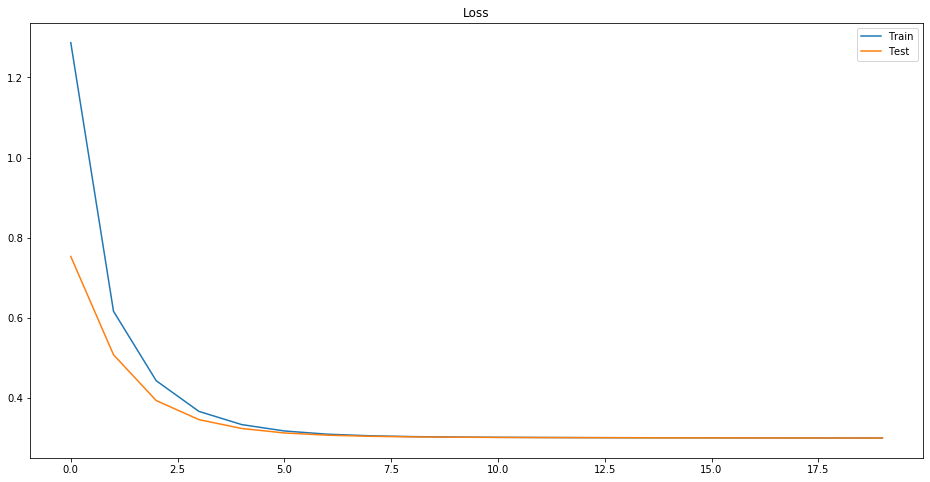

In [29]:
    fig = plt.figure()
    fig.set_size_inches(16,8)

#     ax=fig.add_subplot(3,2,1)
#     ax.plot(hist.history['rmse'])
#     ax.plot(hist.history['mse'])
#     ax.legend(['Metric', 'Loss'])
#     ax.set_title('Train')

#     ax=fig.add_subplot(3,2,2)
#     ax.plot(hist.history['val_rmse'])
#     ax.plot(hist.history['val_mse'])
#     ax.legend(['Metric', 'Loss'])
#     ax.set_title('Test')

    ax=fig.add_subplot(1,1,1)
    ax.plot(hist.history['loss'])
    ax.plot(hist.history['val_loss'])
    ax.legend(['Train', 'Test'])
    ax.set_title('Loss')

#     ax=fig.add_subplot(3,2,4)
#     ax.plot(hist.history['mse'])
#     ax.plot(hist.history['val_mse'])
#     ax.legend(['Train', 'Test'])
#     ax.set_title('Metric')

In [38]:
def get_inputs_subm(idx):
    # FNC inputs
    df_fnc = pd.read_csv('00_Data/fnc_csv/{0}.csv'.format(idx), index_col=0)
    X_fnc = np.array(df_fnc.values).reshape(-1)
    
    # Loading inputs
    df_loading = pd.read_csv('00_Data/loading_csv/{0}.csv'.format(idx), index_col=0)
    X_loading = np.array(df_loading.values).reshape(-1)
    
    #MRI inputs
    patient_SM = h5py.File('00_Data/fMRI_test/{0}.mat'.format(idx), mode='r')
    patient_SM = np.array(patient_SM.get('SM_feature'))
#     patient_SM = mat.transpose([1,2,3,0])

#     print('patient: {idx}')
    
    k = 1
    ki_padding = 3
    
    arr_regions = []
    for i in range(patient_SM.shape[0]):
        sample_map = patient_SM[i,:,:,:]
#         print(len(arr_regions))
        # padding MRI map
        if k > 1:
            map_shape = sample_map.shape
            shape_pad = ((map_shape[0]//k + 1)*k - map_shape[0],
                         (map_shape[1]//k + 1)*k - map_shape[1],
                         (map_shape[2]//k + 1)*k - map_shape[2])

            npad = ((shape_pad[0]//2, (shape_pad[0]//2 if shape_pad[0]%2==0 else shape_pad[0]//2+1)),    
                    (shape_pad[1]//2, (shape_pad[1]//2 if shape_pad[1]%2==0 else shape_pad[1]//2+1)),    
                    (shape_pad[2]//2, (shape_pad[2]//2 if shape_pad[2]%2==0 else shape_pad[2]//2+1)))

            sample_map_padded = np.pad(sample_map, pad_width=npad, mode='constant', constant_values=0)

            sx = sample_map_padded.shape[0] / k
            sy = sample_map_padded.shape[1] / k
            sz = sample_map_padded.shape[2] / k
            for kz in range(k):
                for ky in range(k):
                    for kx in range(k):
                        ki_region = sample_map_padded[int(kx*sx): int(kx*sx + sx - 1), 
                                                     int(ky*sy): int(ky*sy + sy - 1), 
                                                     int(kz*sz): int(kz*sz + sz - 1)]
                        #padding i-th region by 3 pixels
                        ki_region_padded = np.pad(ki_region, pad_width=ki_padding, mode='constant', constant_values=0)
                        arr_regions.append(ki_region_padded)
        else:
            map_padded = np.pad(sample_map, pad_width=ki_padding, mode='constant', constant_values=0)
            arr_regions.append(map_padded)
#             print(map_padded.shape)
    X_mri = np.stack(arr_regions, axis=3)
    
#     X = (X_mri, X_fnc, X_loading)
    return X_mri, X_fnc, X_loading

In [39]:
y_preds = []
for i in TEST_IDS:
    X_mri, X_fnc, X_loading = get_inputs_subm(i)
    X_mri = X_mri.reshape(1,58, 69, 59, 53)
    X_fnc = X_fnc.reshape(1,1378)
    X_loading = X_loading.reshape(1,26)
    preds = model.predict([X_mri, X_fnc, X_loading], batch_size=1)
    y_preds.append(preds)

In [40]:
len(y_preds)

5877

In [41]:
y_preds = np.array(y_preds).flatten()

In [42]:
df_submission = []
i = 0
for idx in TEST_IDS:
    df_submission.append(['{0}_age'.format(idx), y_preds[i]])
    df_submission.append(['{0}_domain1_var1'.format(idx), y_preds[i+1]])
    df_submission.append(['{0}_domain1_var2'.format(idx), y_preds[i+2]])
    df_submission.append(['{0}_domain2_var1'.format(idx), y_preds[i+3]])
    df_submission.append(['{0}_domain2_var2'.format(idx), y_preds[i+4]])
    i += 5

df_submission = pd.DataFrame(df_submission, columns=['Id', 'Predicted'])

In [43]:
df_submission.to_csv('submission_mri-fnc-load_mae_08.csv', index=False)